In [10]:
!pip uninstall numpy matplotlib -y
!pip install numpy matplotlib

Found existing installation: numpy 1.26.3
Uninstalling numpy-1.26.3:
  Successfully uninstalled numpy-1.26.3
Found existing installation: matplotlib 3.8.2
Uninstalling matplotlib-3.8.2:
  Successfully uninstalled matplotlib-3.8.2
  Using cached numpy-1.26.3-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/Users/Pratik/Documents/GitHub/opt_for_pinns/pinns_plotting_env/lib/python3.10/site-packages/matplotlib-3.8.2.dist-info/METADATA'


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [144]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [145]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [146]:
def get_hparam_from_config(config, opt, hparam_name):
    if hparam_name == 'num_neurons':
        return config['num_neurons']
    elif hparam_name == 'adam_lr':
        opt_params = config['opt_params']
        if 'adam_lbfgs' in opt:
            return float(opt_params[opt_params.index('adam_lr') + 1])
        elif opt == 'adam':
            return float(opt_params[opt_params.index('lr') + 1])
        elif opt == 'lbfgs':
            return None

In [147]:
def get_best_min_key(performance_data, mode_val, combo_len):
    # For a fixed value of mode_val, get the key with the lowest minimum value
    # of the performance metric
    best_min_key = None
    best_min_val = np.inf
    for key, val in performance_data.items():
        print(key)
        print(val)
        min_val = np.min(val)
        if combo_len == 1:
            if key == mode_val and min_val < best_min_val:
                best_min_key = key
                best_min_val = min_val
        elif combo_len == 2:
            if key[0] == mode_val and min_val < best_min_val:
                best_min_key = key
                best_min_val = min_val

    return best_min_key


In [148]:
# def get_best_performance(pde_name, pde_params, metric, opt, analysis_mode, extensions, entity_name):
#     proj_name = f'{pde_name}_{extensions[opt]}'
#     mode_name = analysis_mode['name']
#     mode_values = analysis_mode['values']

#     best_results = {val: np.inf for val in mode_values}

#     api = wandb.Api()
#     for run in api.runs(f'{entity_name}/{proj_name}'):
#         if run.state != 'finished':
#             continue
#         config = run.config
#         if config['pde_params'] != pde_params:
#             continue
        
#         if mode_name == 'adam_lr':
#             opt_params = config['opt_params']
#             mode_value = float(opt_params[opt_params.index(mode_name) + 1])
#         else:
#             mode_value = config.get(mode_name)
#         if mode_value in best_results:
#             try:
#                 best_results[mode_value] = \
#                     np.minimum(best_results[mode_value], run.summary[metric]) \
#                         if run.summary[metric] is not None else best_results[mode_value]
#             except:
#                 print(f'Error in {run.name} in {proj_name}, run.summary[metric] = {run.summary[metric]}')

#     return best_results

def get_best_performance(pde_name, pde_params, metric, opt, analysis_mode, other_hparams, extensions, entity_name):
    proj_name = f'{pde_name}_{extensions[opt]}'
    mode_name = analysis_mode['name']
    mode_values = analysis_mode['values']

    other_hparams_name = other_hparams['name']
    performance_data = {}

    combo_len = 1

    api = wandb.Api()
    for run in api.runs(f'{entity_name}/{proj_name}'):
        if run.state != 'finished':
            continue
        config = run.config
        if config['pde_params'] != pde_params:
            continue

        mode_value = get_hparam_from_config(config, opt, mode_name)
        other_hparam_value = get_hparam_from_config(config, opt, other_hparams_name)

        if other_hparam_value is None:
            combo = mode_value
        else:
            combo = (mode_value, other_hparam_value)
            combo_len = 2

        if combo not in performance_data:
            performance_data[combo] = []

        if combo in performance_data:
            if isinstance(run.summary[metric], (float, int)):
                performance_data[combo].append(run.summary[metric])
            else:
                performance_data[combo].append(np.inf) # If 'NaN', set to inf for computation purposes

    print(opt)
    
    # For each mode value, get the key with the best min performance
    best_min_key = {mode_value: get_best_min_key(performance_data, mode_value, combo_len) for mode_value in mode_values}

    # For each mode value, get the best min performance using the best min key
    # Also get the median and max performance corresponding to the best min performance
    best_min_performance = {mode_value: np.min(performance_data[best_min_key[mode_value]]) for mode_value in mode_values}
    median_performance = {mode_value: np.median(performance_data[best_min_key[mode_value]]) for mode_value in mode_values}
    max_performance = {mode_value: np.max(performance_data[best_min_key[mode_value]]) for mode_value in mode_values}
    
    return best_min_performance, median_performance, max_performance

In [149]:
# def get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, extensions, entity_name):
#     opt_best_results = {}
#     for opt in opts:
#         opt_best_results[opt] = get_best_performance(pde_name, pde_params, metric, opt, analysis_mode, extensions, entity_name)
#     return opt_best_results

def get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, other_hparams, extensions, entity_name):
    opt_best_results = {}
    for opt in opts:
        opt_best_results[opt] = get_best_performance(pde_name, pde_params, metric, opt, analysis_mode, other_hparams, extensions, entity_name)
    return opt_best_results

In [150]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    if pde_name == "reaction":
        return f'Reaction, $\\rho = {pde_params[1]}$'
    elif pde_name == "reaction_diffusion":
        return f'Reaction-diffusion, $\\nu = {pde_params[1]}, \\rho = {pde_params[3]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

In [151]:
# def plot_best_performance_multi_pde(pdes, metrics, opts, analysis_mode, extensions, entity_name,
#                                      opt_names, metric_names, opt_colors, font_size, folder_path,
#                                        filename):
#     mpl.rcParams.update({'font.size': font_size})

#     nrows = len(metrics)
#     ncols = len(pdes)

#     fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))  # Adjust figsize as needed
#     mode_values = analysis_mode['values']
#     mode_label = analysis_mode['label']

#     for row, metric in enumerate(metrics):
#         for col, (pde_name, pde_params) in enumerate(pdes):
#             opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, extensions, entity_name)
#             width = 0.15  # Width of the bars in the bar plot

#             ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])
#             for i, opt in enumerate(opts):
#                 ax.bar(np.arange(len(mode_values)) + i * width, [opt_best_results[opt][val] for val in mode_values],
#                         width, color=opt_colors[opt], label=opt_names[opt])

#             ax.set_yscale('log')
#             ax.set_ylabel(metric_names[metric])
#             ax.set_xlabel(mode_label)
#             ax.set_xticks(np.arange(len(mode_values)) + (len(opts) - 1) * width / 2)
#             ax.set_xticklabels(mode_values)
#             ax.set_title(get_title(pde_name, pde_params))

#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))
#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path)

#     filename = filename + '_' + analysis_mode['name'] + '.pdf'
#     fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
#     plt.show()

# def plot_best_median_performance_multi_pde(pdes, metrics, opts, analysis_mode, other_hparams, extensions, entity_name,
#                                      opt_names, metric_names, opt_colors, font_size, folder_path,
#                                        filename):
#     mpl.rcParams.update({'font.size': font_size})

#     nrows = len(metrics)
#     ncols = len(pdes)

#     fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))  # Adjust figsize as needed
#     mode_values = analysis_mode['values']
#     mode_label = analysis_mode['label']

#     for row, metric in enumerate(metrics):
#         for col, (pde_name, pde_params) in enumerate(pdes):
#             opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, other_hparams, extensions, entity_name)
#             width = 0.15  # Width of the bars in the bar plot

#             ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])
#             for i, opt in enumerate(opts):
#                 ax.bar(np.arange(len(mode_values)) + i * width, [opt_best_results[opt][0][val] for val in mode_values],
#                         width, color=opt_colors[opt], label=opt_names[opt])

#             ax.set_yscale('log')
#             ax.set_ylabel(metric_names[metric])
#             ax.set_xlabel(mode_label)
#             ax.set_xticks(np.arange(len(mode_values)) + (len(opts) - 1) * width / 2)
#             ax.set_xticklabels(mode_values)
#             ax.set_title(get_title(pde_name, pde_params))

#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))
#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path)

#     filename = filename + '_' + analysis_mode['name'] + '.pdf'
#     fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
#     plt.show()

def plot_best_median_performance_multi_pde(pdes, metrics, opts, analysis_mode, other_hparams, extensions, entity_name,
                                     opt_names, metric_names, opt_colors, font_size, folder_path,
                                       filename):
    mpl.rcParams.update({'font.size': font_size})

    nrows = len(metrics)
    ncols = len(pdes)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))  # Adjust figsize as needed

    mode_values = analysis_mode['values']
    mode_label = analysis_mode['label']

    custom_legend_optimizers = [mpl.lines.Line2D([0], [0], color=opt_colors[opt], linestyle='-', label=opt_names[opt]) for opt in opts]
    stat_markers = ['o', 's', '^']
    stat_labels = ['Min', 'Median', 'Max']
    custom_legend_stats = [mpl.lines.Line2D([0], [0], color='black', marker=stat_markers[i], linestyle='None',
                                          markersize=6, label=stat_labels[i]) for i in range(3)]

    for row, metric in enumerate(metrics):
        for col, (pde_name, pde_params) in enumerate(pdes):
            opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, other_hparams, extensions, entity_name)
            
            ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])
            for i, opt in enumerate(opts):
                x_positions = np.arange(len(mode_values)) + i * 0.15
                for j, _ in enumerate(['min', 'median', 'max']):
                    y_values = [opt_best_results[opt][j][val] for val in mode_values]
                    ax.scatter(x_positions, y_values, label=f"{opt_names[opt]}", 
                               color=opt_colors[opt], marker=stat_markers[j])

            ax.set_yscale('log')
            ax.set_ylabel(metric_names[metric])
            ax.set_xlabel(mode_label)
            ax.set_xticks(np.arange(len(mode_values)) + (len(opts) - 1) * 0.15 / 2)
            ax.set_xticklabels(mode_values)
            ax.set_title(get_title(pde_name, pde_params))

    # Adjust the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique_labels, unique_handles = [], []
    # for handle, label in zip(handles, labels):
    #     if label not in unique_labels:
    #         unique_labels.append(label)
    #         unique_handles.append(handle)
    all_handles = custom_legend_optimizers + custom_legend_stats
    fig.legend(all_handles, [h.get_label() for h in all_handles], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    # by_label = dict(zip(labels, handles))
    # fig.legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    filename = filename + '_' + analysis_mode['name'] + '.pdf'
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

In [152]:
entity_name = 'sketchy-opts'
extensions = {
    'adam': 'adam_final',
    'lbfgs': 'lbfgs_final',
    'adam_lbfgs': 'adam_lbfgs_final',
    'adam_lbfgs_11k': 'adam_lbfgs_final_11k',
    'adam_lbfgs_31k': 'adam_lbfgs_final_31k'
}
opt_names = {
    'adam': 'Adam',
    'lbfgs': 'L-BFGS',
    'adam_lbfgs': 'Adam + L-BFGS (1k)',
    'adam_lbfgs_11k': 'Adam + L-BFGS (11k)',
    'adam_lbfgs_31k': 'Adam + L-BFGS (31k)'
}
opt_colors = {
    'adam': 'tab:blue',
    'lbfgs': 'tab:orange',
    'adam_lbfgs': 'tab:green',
    'adam_lbfgs_11k': 'tab:red',
    'adam_lbfgs_31k': 'tab:purple'
}
metric_names = {
    'train/l2re': 'Training L2RE',
    'train/l1re': 'Training L1RE',
    'test/l2re': 'Test L2RE',
    'test/l1re': 'Test L1RE',
    'loss': 'Loss'
}

adam
(400, 0.1)
[0.49805447459220886, 0.4980545341968536, 0.4980700314044952, 0.7989122867584229, 0.49805447459220886]
(400, 0.01)
[0.49805447459220886, 0.49805542826652527, 0.49805447459220886, 0.49805447459220886, 0.5097224116325378]
(400, 0.001)
[0.00854271650314331, 0.00018090830417349937, 0.009775606915354729, 0.023374546319246292, 0.01151751447468996]
(400, 1e-05)
[0.030712299048900604, 0.027845649048686028, 0.02511506713926792, 0.03085450641810894, 0.022938868030905724]
(400, 0.0001)
[0.013237286359071732, 0.01375605072826147, 0.01451539807021618, 0.012758173048496246, 0.011786052025854588]
(200, 0.1)
[0.4980550706386566, 0.49805447459220886, 0.4980546534061432, 0.4985571205615998, 0.4998810291290283]
(200, 0.01)
[0.4981125295162201, 0.49805447459220886, 0.49805447459220886, 0.498111367225647, 0.49805447459220886]
(200, 0.001)
[0.00022000230092089623, 0.00021388192544691265, 0.0014874259941279888, 0.0002706786326598376, 0.0002883905835915357]
(200, 1e-05)
[0.028260312974452972, 

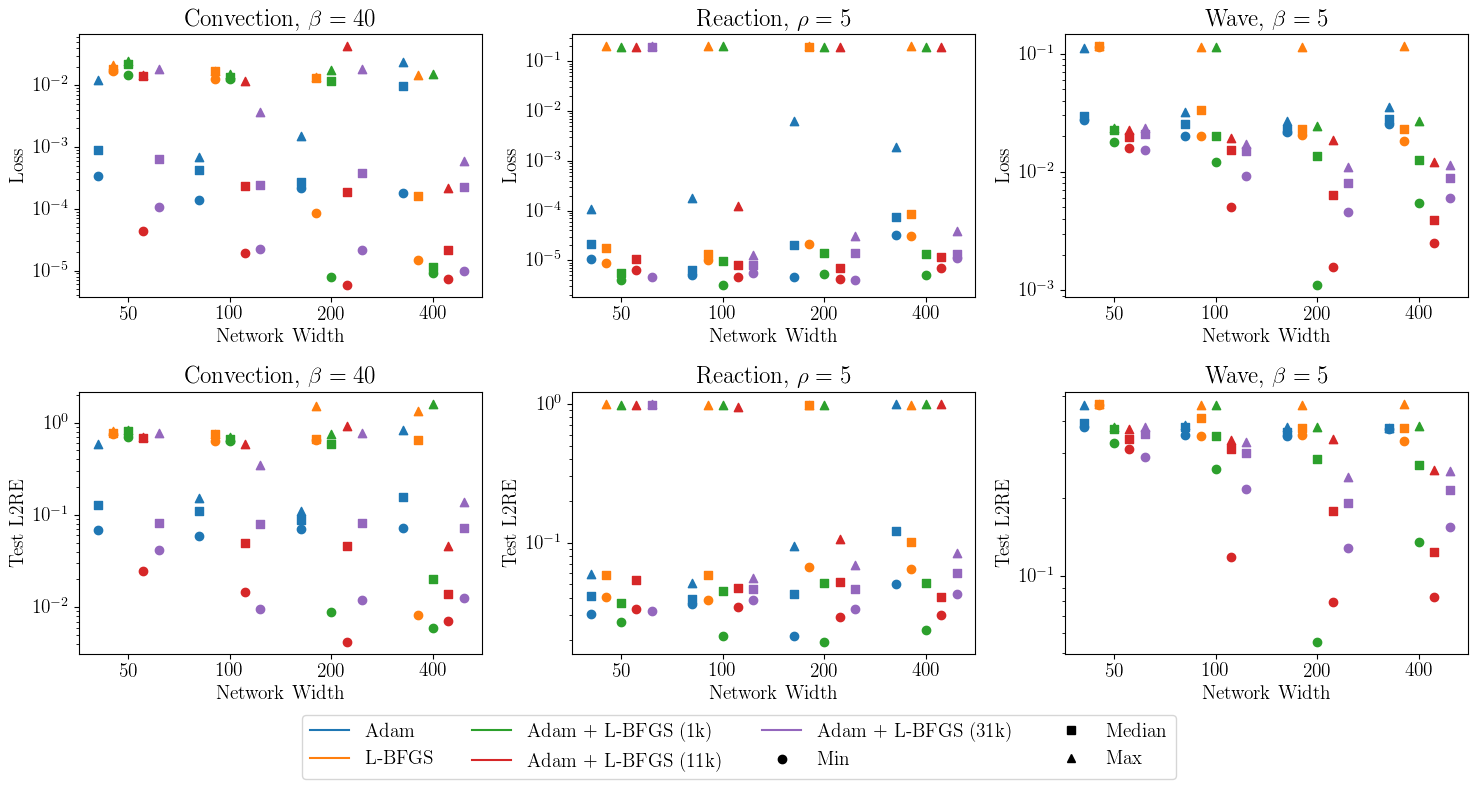

In [153]:
pdes = [('convection', ['beta', '40']), ('reaction', ['rho', '5']), ('wave', ['beta', '5'])]
metrics = ['loss', 'test/l2re']
opts = ['adam', 'lbfgs', 'adam_lbfgs', 'adam_lbfgs_11k', 'adam_lbfgs_31k']
analysis_mode_width = {
    'name': 'num_neurons',
    'values': [50, 100, 200, 400],
    'label': 'Network Width'
}
# opts = ['adam_lbfgs', 'adam_lbfgs_11k', 'adam_lbfgs_31k']
analysis_mode_adam_lr = {
    'name': 'adam_lr',
    'values': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'label': 'Learning Rate'
}

folder_path = 'opt_comparison_plots'
filename = 'loss_l2re'

# plot_best_performance_multi_pde(pdes, metrics, opts, analysis_mode_width, extensions, entity_name, opt_names, metric_names, opt_colors,
#                                 font_size=14, folder_path=folder_path, filename=filename)

plot_best_median_performance_multi_pde(pdes, metrics, opts, analysis_mode_width, analysis_mode_adam_lr, extensions, entity_name, opt_names, metric_names, opt_colors,
                                font_size=14, folder_path=folder_path, filename=filename)